# Power Outages

# Summary of Findings


### Introduction
1. The dataset contains information of 1535 power outage events happened in United States across different states.


2. The classification problem that I want to answer is how characteristics of power outage events could be used to predict whether the outage is severe or not severe.


3. To predict whether the outage event is severe or not severe, I choose the following features:
    - `YEAR`
        - The year when a power outage event happened
        - People have relied more on electronic devices and demanded more electricity supply in recent years than they did in early years. Therefore, outage events happened in recent years would likely affect more customers and they might be severe.
    - `MONTH`
        - The month when a power outage event happened
        - People use air condition more often in summer (June to August) and winter (November to January). Hence, power outage events happened in these periods could affect more customers than those happened in spring and fall and they might be severe.
    - `POSTAL.CODE`
        - Postal code of the state where a power outage event happened
        - Power outage events happened in more populated states, such as California and New York, could affect more people than those happened in less populated states.
    - `CLIMATE.CATEGORY`
        - Describes climate episodes when the power outage happened as warm, cold, or normal
        - In different climate episodes, people might demand different amount of electricity. Hence, outage events happened in different climate episodes might affect different number of customers, and their severity might be different.
    - `CAUSE.CATEGORY`
        - The cause of power outage
        - (Hypothetical Case) Severe weather might destroy the central power system of a city and affect all people living in the city, so outage events caused by severe weather are more likely to be severe. 
        - Failure of one particular power equipment might affect customers living in the corresponding region of the city and have less impact, so these outage events are less likely to be severe.
    - `OUTAGE.DURATION`
        - Describes how long power outage lasts in minutes
        - Longer the outage endures, more customers affected.
    - `POPULATION`
        - Describes the population of states where outage happened
        - If there are many people living in the state where power outage happened, then outage would affect a large number of people and hence is likely to be severe.
        - If there are not many people living in the state where power outage happened, then outage would not impact a lot customers and hence is less likely to be severe.
    - `CUSTOMERS.AFFECTED`
        - The number of customers affected by outage events
        - The values are used to create severity labels of outage events
        
        
4. I care about how well my classification model labels power outage event as severe. If the model labels one outage event as not severe but this outage is actually severe, the repair team might not take it seriously and repair it immediately and hence customers are affected more significantly. Since F1 score is a measure of how well a test labels positive instances, I choose it as evaluation metric.

### Baseline Model
    
1. Whether the outage is severe or not severe is determined by the number of customers affected. I use the average number of customers affected as the threshold. If the number of customers affected by the outage is larger than or equal to the threshold, then the outage is severe. Otherwise, it is not severe. I save those labels in a new column `SEVERITY.LABEL`.


2. My baseline model is a Logistic Regression model fitted on 7 features I choose:
    - `POSTAL.CODE`, `CLIMATE.CATEGORY`, `CAUSE.CATEGORY` are nominal data and they are one-hot encoded
    - `YEAR` and `MONTH` are ordinal data and they are ordinal encoded
    - `OUTAGE.DURATION (Mins)` and `POPULATION` are quantitative data and they are not transformed in building baseline model


3. F1 score for training data is 0.0597, while F1 score for testing data is 0.065. These two F1 scores are very small and they indicate that my classification model performs very badly on labeling severe power outage event in both training and testing data. This situation is very bad because this model could not identify almost all severe outage events and then outage issue might not be fixed immediately. Ultimately, lives of customers would be impacted more significantly.

### Final Model
    
1. After I plot the distribution of `OUTAGE.DURATION (Mins)` and `POPULATION`, I find that they are very spread out and extremely skewed to the left, which is not helpful for classification model. Therefore, I plot the distribution of log and square root of `OUTAGE.DURATION (Mins)` and `POPULATION`. By comparison, logged `OUTAGE.DURATION (Mins)` and logged `POPULATION` are more normally distributed and less spread out than square root of both `OUTAGE.DURATION (Mins)` and `POPULATION`. Hence, I engineer `OUTAGE.DURATION (Mins)` and `POPULATION` using log transformation. Since `OUTAGE.DURATION (Mins)` contains values of 0 but log of 0 is undefined, I apply log transformation to nonzero `OUTAGE.DURATION (Mins)`, store logged `OUTAGE.DURATION (Mins)` into `LOGGED.OUTAGE.DURATION (Mins)`, and drop `OUTAGE.DURATION (Mins)` from outage dataset.


2. My model is binary classification model that labels outage as severe or not severe. Since Logistic Regression model is designed for binary classification, I choose it as my model. I set solver parameter to 'liblinear' because power outage dataset is a small dataset of only 1525 rows and 'liblinear' is a good choice for optimizing classification model's performance on small dataset. According to documentation of Logistic Regression function in sklearn package, for liblinear solver, I should set verbose to any positive number for verbosity. Hence I set verbose parameter to 2. Then, I use a for-loop to iterate over 150 possible values of max_iter parameter. A model is created for each possible value of max_iter and f1 score of each model on testing data is stored into a list. The result shows that the value of max_iter parameter that produces best f1 score is 100. Hence, I create a Logistic Regression model with parameters as follows: solver = 'lbfgs', verbose = 2, max_iter = 100.


3. F1 score of final model on training data is 0.632, while f1 score of testing data is 0.657. These scores are much higher than f1 scores of baseline model. So, this final model improves significantly on labeling power outage as severe from baseline model.


### Fairness Evaluation
1. For this dataset, I choose `POSTAL.CODE` to construct my subset. I want to explore whether my model is fairer for labeling power outage as severe given the outage is actually severe in western or non western states.


2. According to https://www.nytimes.com/1981/05/21/us/12-western-states-seek-control-of-554-million-acres-of-us-land.html, I identify Montana, Wyoming, Colorado, New Mexico, Idaho, Washington, Oregon, Alaska, Arizona, California, Utah, and Nevada as western states. Then, I create a column `IS.WESTERN` that stores boolean values that indicate whether outage happened in western or non western state. Next, the final model is fitted on the entire data and predicts severity label. Predicted labels are stored into column `PREDS`.


3. Since I care about how accurately my classification model labels power outage events as severe given the outage is actually severe, I use True Positive Parity as my parity measure. Here, TP-Parity represents the proportion of power outage labled as severe given that it is acutally severe across western and nonwestern states. Null, alternative hypotheses, test statistic, and significance level are as follow:
    - Null Hypothesis: my model is fair and recall scores for western and nonwestern outage subsets are roughly the same
    - Alternative Hypothesis: my model is unfair and recall score for western outage subset is higher than that for nonwestern outage subset
    - Test Statistic: the difference between recall scores for western and non western subsets
    - Significance Level: 0.01


4. P-value from permutation test is equal to 0, which is smaller than significance level of 0.01. Hence, the null hypothesis that my model is fair and recall scores for western and nonwestern outage subsets are roughly the same is rejected.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning

**After reading in power outage dataset, I first drop top 4 rows since they are headers of the dataset and many entries are NaN values. Then, I drop the column 'Major power outage events in the continental U.S' because all entries in this column are NaN values as well.**

In [3]:
power_outage = pd.read_excel('outage.xlsx')
power_outage = power_outage.loc[4:].drop(columns=['Major power outage events in the continental U.S.'])

**When I look into new power outage dataset, I find that each entry in the first row describes values in each column and each entry in the second row is unit of values in corresponding column. So, I combine first two rows and rename dataset's columns using entries in combined rows.**

In [4]:
# replace each unit in second row of the dataset with their abbreviations. For example, I use MW to represent Megawatt.
print(power_outage.iloc[1].unique())
replaced_vals = ['', '', ' (Y:M:D)', ' (H:M:S)', ' (Mins)', ' (MW)', ' (cts/kWh)', ' (Mh)', ' (%)', ' ($)',
                 ' (/)', ' (PPSM)']
power_outage.iloc[1] = power_outage.iloc[1].replace(dict(zip(power_outage.iloc[1].unique(), replaced_vals)))

[nan 'numeric' 'Day of the week, Month Day, Year'
 'Hour:Minute:Second (AM / PM)' 'mins' 'Megawatt' 'cents / kilowatt-hour'
 'Megawatt-hour' '%' 'USD' 'fraction' 'persons per square mile']


In [5]:
# Rename the column using the combined first two rows
power_outage.columns = power_outage.iloc[0] + power_outage.iloc[1]

In [6]:
columns_want = ['YEAR', 'MONTH', 'POSTAL.CODE', 'CLIMATE.CATEGORY',
                'CAUSE.CATEGORY', 'OUTAGE.DURATION (Mins)', 'CUSTOMERS.AFFECTED', 'POPULATION']
# drop first two rows, reset index, take only columns that I want
power_outage = power_outage.drop([4, 5]).reset_index().drop(columns = ['index', 'OBS'])[columns_want]

In [7]:
# convert the type of values in 'OUTAGE.DURATION (Mins)', 'CUSTOMERS.AFFECTED' to float and 'POPULATION' to int 
power_outage['OUTAGE.DURATION (Mins)'] = power_outage['OUTAGE.DURATION (Mins)'].astype(float)
power_outage['CUSTOMERS.AFFECTED'] = power_outage['CUSTOMERS.AFFECTED'].astype(float)
power_outage['POPULATION'] = power_outage['POPULATION'].astype(int)

**Since I would perform one-hot encoding and ordinal encoding on `YEAR`, `MONTH`, `POSTAL.CODE`, `CLIMATE.CATEGORY`, `CAUSE.CATEGORY` columns and there are only 9 nan values in these columns, I drop these 9 rows from outage dataset.**

In [8]:
power_outage.isnull().sum()

YEAR                        0
MONTH                       9
POSTAL.CODE                 0
CLIMATE.CATEGORY            9
CAUSE.CATEGORY              0
OUTAGE.DURATION (Mins)     58
CUSTOMERS.AFFECTED        443
POPULATION                  0
dtype: int64

In [9]:
cate_cols = ['YEAR', 'MONTH', 'POSTAL.CODE', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']
power_outage = power_outage.dropna(subset = cate_cols)

**Since there are 441 rows with NaN values in `CUSTOMERS.AFFECTED` and 58 rows with NaN values in `OUTAGE.DURATION (Mins)`
but this dataset only have 1525 rows, simply dropping rows with NaN values in these two columns would lose much information about other columns. Therefore, I calculate the average number of customers affected and average outage duration time in minutes in different causation categories groups. Then, I impute missing values in `CUSTOMERS.AFFECTED` and `OUTAGE.DURATION (Mins)` using mean values in different groups.**

In [10]:
# calculate the average number of customers affected by outage events caused by different reasons
fillna_customers = power_outage.groupby('CAUSE.CATEGORY').mean()['CUSTOMERS.AFFECTED'].astype(int).to_dict()
fillna_customers

{'equipment failure': 109770,
 'fuel supply emergency': 0,
 'intentional attack': 1790,
 'islanding': 6169,
 'public appeal': 7618,
 'severe weather': 188944,
 'system operability disruption': 211066}

In [11]:
# calculate the average outage duration time in minutes of outage events caused by different reasons
fillna_duration = power_outage.groupby('CAUSE.CATEGORY').mean()['OUTAGE.DURATION (Mins)'].astype(int).to_dict()
fillna_duration

{'equipment failure': 1816,
 'fuel supply emergency': 13484,
 'intentional attack': 429,
 'islanding': 200,
 'public appeal': 1468,
 'severe weather': 3883,
 'system operability disruption': 728}

In [12]:
# create a function that fill the missing value in `CUSTOMERS.AFFECTED` and
# `OUTAGE.DURATION (Mins)` using average values in different groups
def fillna_outage(x):
    if np.isnan(x['CUSTOMERS.AFFECTED']):
        x['CUSTOMERS.AFFECTED'] = fillna_customers[x['CAUSE.CATEGORY']]
    if np.isnan(x['OUTAGE.DURATION (Mins)']):
        x['OUTAGE.DURATION (Mins)'] = fillna_duration[x['CAUSE.CATEGORY']]
    return x

In [13]:
# fill nan values
power_outage = power_outage.apply(fillna_outage, axis = 1)

In [14]:
power_outage.isnull().sum()

YEAR                      0
MONTH                     0
POSTAL.CODE               0
CLIMATE.CATEGORY          0
CAUSE.CATEGORY            0
OUTAGE.DURATION (Mins)    0
CUSTOMERS.AFFECTED        0
POPULATION                0
dtype: int64

**I use the average number of customers affected as the threshold to decide whether the outage is severe. If the number of customers affected of the outage is larger than or equal to the threshold, then the outage is severe. Otherwise, it is not severe. I save the labels in a new column `SEVERITY.LABEL`**

In [15]:
power_outage['SEVERITY.LABEL'] = power_outage['CUSTOMERS.AFFECTED'] >= power_outage['CUSTOMERS.AFFECTED'].mean()

### Baseline Model

**Here, I encode `POSTAL.CODE`, `CLIMATE.CATEGORY`, `CAUSE.CATEGORY` using one-hot encoding and encode `YEAR` and `MONTH` using ordinal encoding. `OUTAGE.DURATION (Mins)` and `POPULATION` column is not transformed. Then I create a pipeline that transforms columns and fits a Logistic Regression model on these transformed columns.**

In [16]:
cate_cols

['YEAR', 'MONTH', 'POSTAL.CODE', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']

In [17]:
ct = ColumnTransformer([('one-hot', OneHotEncoder(), cate_cols[2:]),
                        ('ordinal', OrdinalEncoder(), cate_cols[:2])], remainder = 'passthrough')
pl = Pipeline([('trans', ct), ('lr', LogisticRegression())])

In [18]:
# split train and test data
x_train, x_test, y_train, y_test = train_test_split(power_outage.drop(columns = ['CUSTOMERS.AFFECTED', 'SEVERITY.LABEL']),
                                                    power_outage['SEVERITY.LABEL'])

**F1 score for training data is 0.0597, while F1 score for testing data is 0.065. These two F1 scores are very small and they indicate that my classification model performs very badly on labeling severe power outage event in both training and testing data.**

In [19]:
pl.fit(x_train, y_train)
print('Training F1 Score', f1_score(y_train, pl.predict(x_train)))
print('Testing F1 Score', f1_score(y_test, pl.predict(x_test)))

Training F1 Score 0.059782608695652176
Testing F1 Score 0.06504065040650406


### Final Model

**The plot below shows the distribution of outage durations in minutes. The graph shows that outage duration time (in minutes) is very spread out and extremely skewed to the left.**

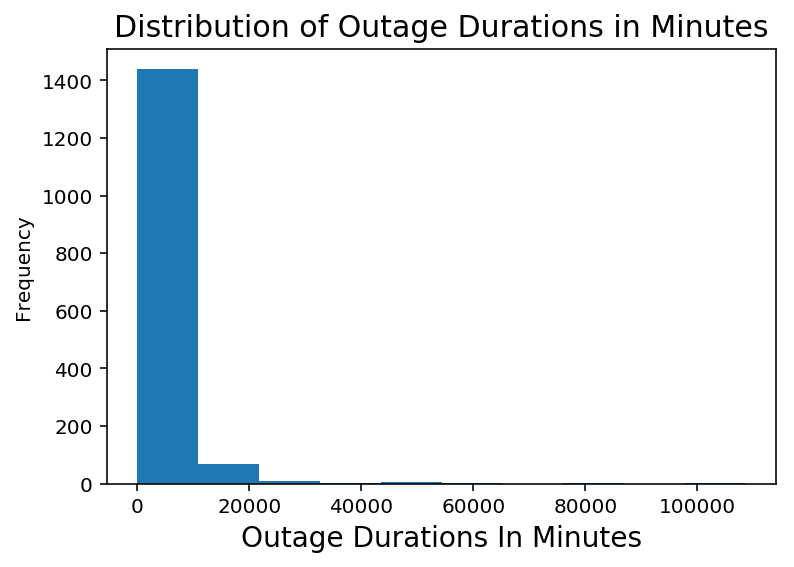

In [20]:
power_outage['OUTAGE.DURATION (Mins)'].plot('hist')
plt.xlabel('Outage Durations In Minutes', fontsize = 14)
plt.title('Distribution of Outage Durations in Minutes', fontsize = 15)
plt.show()

**Here, I plot the distribution of log and square root of outage duration in minutes. By comparison, log of outage duration in minutes is more normally distributed. Hence, I decide to engineer `OUTAGE.DURATION (Mins)` using log transformation.**

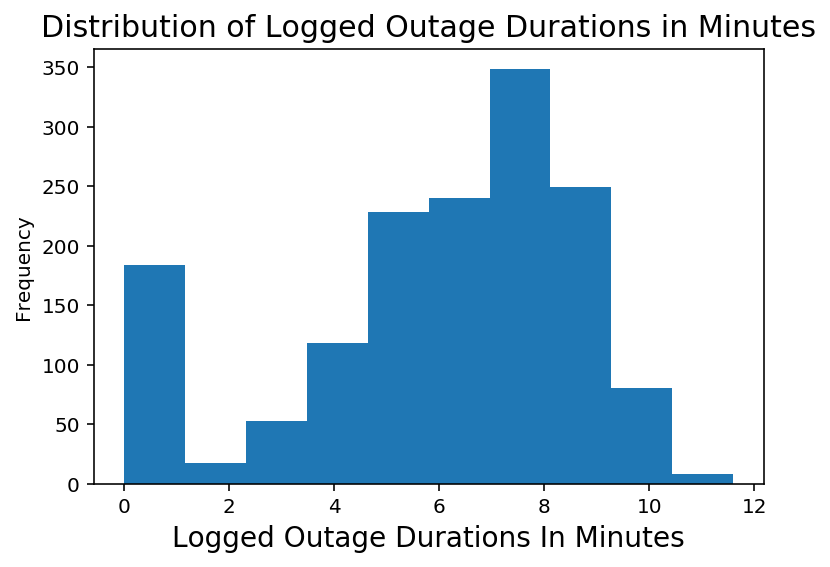

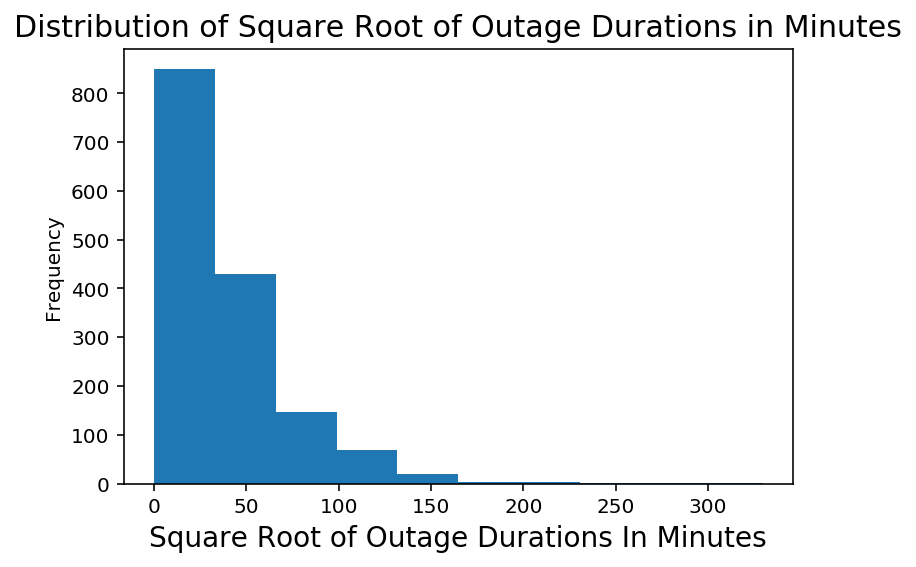

In [21]:
# Since `OUTAGE.DURATION (Mins)` contains values of 0 and log of 0 is undefined, I leave out 0 values
# and apply log transformation to nonzero outage duration time
power_outage['OUTAGE.DURATION (Mins)'].apply(lambda x: x if x == 0 else np.log(x)).plot('hist')
# Plot of log of outage duration in minutes
plt.xlabel('Logged Outage Durations In Minutes', fontsize = 14)
plt.title('Distribution of Logged Outage Durations in Minutes', fontsize = 15)
plt.show()
# Plot of square root of outage durations in minutes
np.sqrt(power_outage['OUTAGE.DURATION (Mins)']).plot('hist')
plt.xlabel('Square Root of Outage Durations In Minutes', fontsize = 14)
plt.title('Distribution of Square Root of Outage Durations in Minutes', fontsize = 15)
plt.show()

**The plot below shows the distribution of population of states where outage happened. The graph shows that `POPULATION` is skewed to the left and is very spread out.**

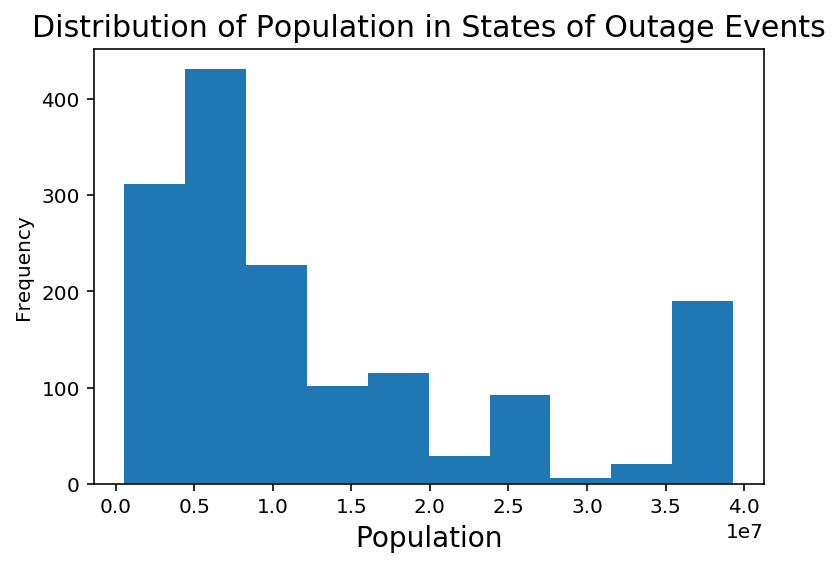

In [23]:
power_outage['POPULATION'].plot('hist')
plt.xlabel('Population', fontsize = 14)
plt.title('Distribution of Population in States of Outage Events', fontsize = 15)
plt.show()

**Here, I apply both log and square root transformation to `POPULATION` and plot the distribution of transformed values. From the plots, I find the logged population is more normally distributed and it is less spread out.**

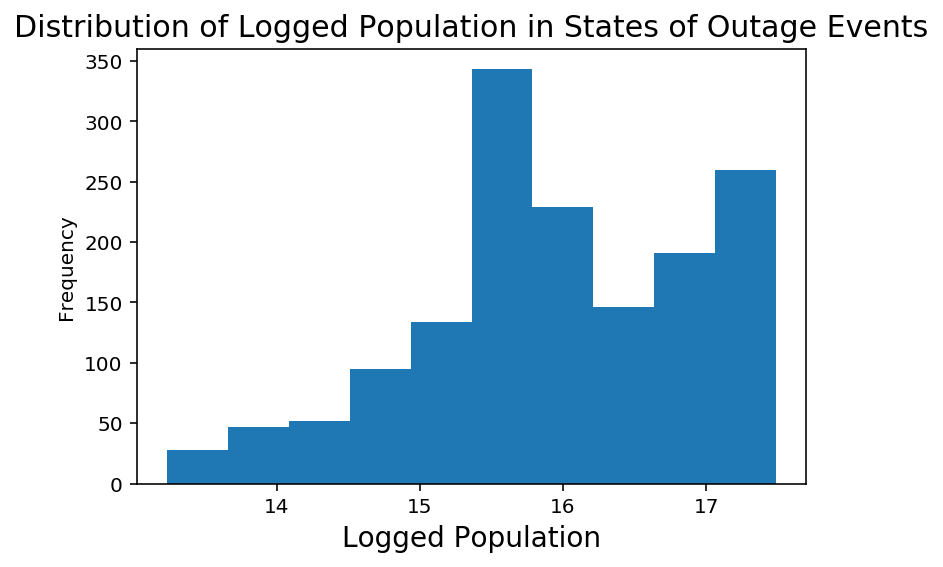

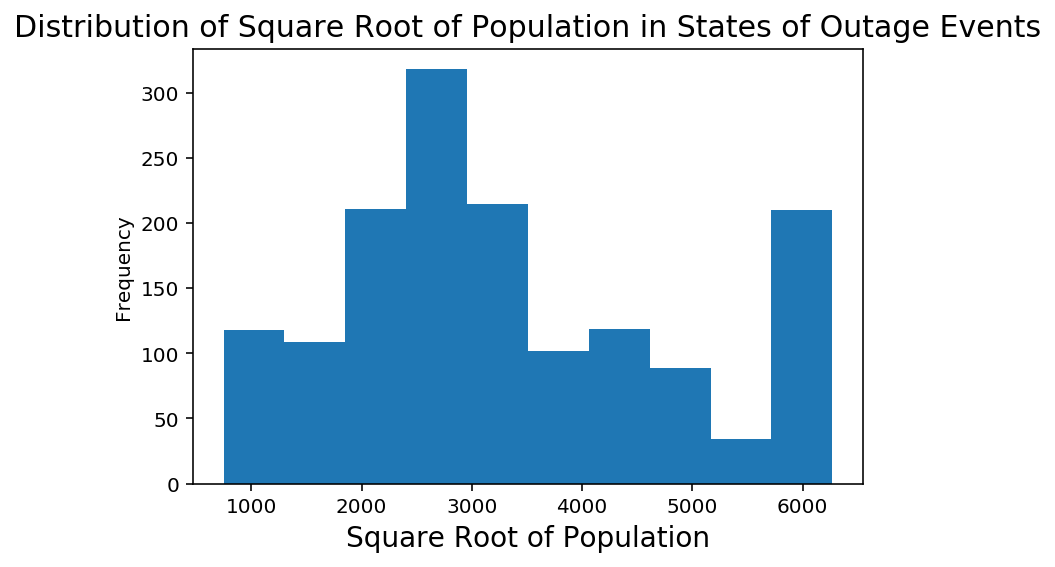

In [25]:
# Plot of log of population
np.log(power_outage['POPULATION']).plot('hist')
plt.xlabel('Logged Population', fontsize = 14)
plt.title('Distribution of Logged Population in States of Outage Events', fontsize = 15)
plt.show()
# Plot of square root of population
np.sqrt(power_outage['POPULATION']).plot('hist')
plt.xlabel('Square Root of Population', fontsize = 14)
plt.title('Distribution of Square Root of Population in States of Outage Events', fontsize = 15)
plt.show()

**Based on analysis performed above,  I engineer `OUTAGE.DURATION (Mins)` and `POPULATION` features using log transformation. Also, I encode `POSTAL.CODE`, `CLIMATE.CATEGORY`, `CAUSE.CATEGORY` using one-hot encoding and encode `YEAR` and `MONTH` using ordinal encoding. Then I create a pipeline that transforms columns and fits a Logistic Regression model on these transformed columns.**

In [26]:
# Since 'OUTAGE.DURATION (Mins)' contains values of 0 but log of 0 is undefined, I only apply log transformation to
# nonzero outage duration time, store logged duration time into a new column
power_outage['LOGGED.OUTAGE.DURATION (Mins)'] = power_outage['OUTAGE.DURATION (Mins)'].apply(lambda x: 
                                                                                             x if x == 0 else np.log(x))
# Drop the original outage duration column
power_outage = power_outage.drop(columns = ['OUTAGE.DURATION (Mins)'])

In [27]:
# Pipeline
ct = ColumnTransformer([('one-hot', OneHotEncoder(), cate_cols[2:]),
                        ('ordinal', OrdinalEncoder(), cate_cols[:2]),
                        ('log', FunctionTransformer(np.log), ['POPULATION'])], remainder = 'passthrough')

In [28]:
# split train and test data
x_train, x_test, y_train, y_test = train_test_split(power_outage.drop(columns = ['CUSTOMERS.AFFECTED', 'SEVERITY.LABEL']),
                                                    power_outage['SEVERITY.LABEL'], test_size = 0.3)

**Here, I use a for-loop to iterate over 150 possible values of max_iter parameter of Logistic Regression model. A model is created for each value of max_iter and f1 score of each model on testing data is stored into a list.**

In [29]:
test_f1_score = []
# Possible values for max_iter parameter is from 50 to 200
range_param = np.arange(50, 201)
for i in range_param:
    # Create pipeline for each max_iter value
    pl = Pipeline([('trans', ct), ('lr', LogisticRegression(solver='liblinear', verbose = 2, max_iter = i))])
    pl.fit(x_train, y_train)
    # Append f1 score of each model on testing data
    test_f1_score.append(f1_score(y_test, pl.predict(x_test)))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

**It shows that the value of max_iter parameter that produces best f1 score is 100**

In [30]:
best_max_iter = test_f1_score.index(np.max(test_f1_score)) + 100
best_max_iter

100

**Create a pipeline of column transformers and Logistic Regression model with parameters solver = 'lbfgs', verbose = 2, max_iter = 100. I set solver to 'liblinear' algorithm because it is a small dataset of only 1525 rows and 'liblinear' is a good choice for optimizing model's performance on small dataset. According to documentation of Logistic Regression function in sklearn, for liblinear solver, I should set verbose to any positive number for verbosity and hence I set verbose parameter to 2**

In [31]:
power_outage.shape

(1525, 9)

In [32]:
pl = Pipeline([('trans', ct), ('lr', LogisticRegression(solver='liblinear', verbose = 2, max_iter = best_max_iter))])

In [33]:
# split train and test data
x_train, x_test, y_train, y_test = train_test_split(power_outage.drop(columns = ['CUSTOMERS.AFFECTED', 'SEVERITY.LABEL']),
                                                    power_outage['SEVERITY.LABEL'], test_size = 0.3)

**F1 score of improved Logistic Regression model on training data is 0.632, while f1 score of testing data is 0.657. These scores are much higher than f1 scores of baseline model. So, this final model improves significantly on labeling power outage as severe from baseline model.**

In [341]:
pl.fit(x_train, y_train)
print('Training F1 Score', f1_score(y_train, pl.predict(x_train)))
print('Testing F1 Score', f1_score(y_test, pl.predict(x_test)))

[LibLinear]Training F1 Score 0.6322188449848025
Testing F1 Score 0.657142857142857


### Fairness Evaluation

**For this dataset, I choose `POSTAL.CODE` to construct my subset. I want to explore whether my model is fairer for labeling power outage as severe given the outage is actually severe in western or non western states. According to https://www.nytimes.com/1981/05/21/us/12-western-states-seek-control-of-554-million-acres-of-us-land.html, I identify Montana, Wyoming, Colorado, New Mexico, Idaho, Washington, Oregon, Alaska, Arizona, California, Utah, and Nevada as western states.  Then, I create a column `IS.WESTERN` that stores boolean values that indicate whether outage happened in western or non western state.**

In [34]:
western_states = ['WA', 'AZ', 'UT', 'OR', 'MT', 'CA', 'WY', 'NM', 'NV', 'HI', 'ID', 'AK']

In [35]:
power_outage['IS.WESTERN'] = power_outage['POSTAL.CODE'].isin(western_states)

**Here, the final model is fitted on entire data and predicts severity label. Predicted labels are stored into column `PREDS`.**

In [36]:
pl = Pipeline([('trans', ct), ('lr', LogisticRegression(solver='liblinear', verbose = 2, max_iter = best_max_iter))])

In [37]:
pl.fit(power_outage.drop(columns = ['CUSTOMERS.AFFECTED', 'SEVERITY.LABEL']), power_outage['SEVERITY.LABEL'])

[LibLinear]

Pipeline(memory=None,
     steps=[('trans', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('one-hot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=2, warm_start=False))])

In [38]:
power_outage['PREDS'] = pl.predict(power_outage.drop(columns = ['CUSTOMERS.AFFECTED', 'SEVERITY.LABEL']))

**Since I care about how accurately my classification model labels power outage events as severe given the outage is actually severe, I use True Positive Parity as my parity measure. Here, TP-Parity represents the proportion of power outage labled as severe given that it is acutally severe across western and nonwestern states. Null, alternative hypotheses, test statistic, and significance level are as follow:**
   - Null Hypothesis: my model is fair and recall scores of western and nonwestern outage subsets are roughly the same
   - Alternative Hypothesis: my model is unfair and recall score of western outage subset is higher than that of nonwestern outage subset
   - Test Statistic: the difference between recall scores of western and non western subsets
   - Significance Level: 0.01

In [39]:
# Groupby 'IS.WESTERN' and calculate observed test statistic
recall_df = power_outage.groupby('IS.WESTERN').apply(lambda x: 
                        recall_score(x['SEVERITY.LABEL'], x['PREDS'])).rename('Recall Score').to_frame()
display(recall_df)
observed_diff = recall_df.diff().iloc[-1]

,Recall Score
IS.WESTERN,
False,0.645429
True,0.821782


**Permutation Test Performed Under Null Hypothesis**

In [40]:
results = []
for i in range(100):
    recall = (
        # Select relevant columns
        power_outage[['IS.WESTERN', 'PREDS', 'SEVERITY.LABEL']]
        # Shuffle western and non western labels
        .assign(**{'IS.WESTERN': (power_outage['IS.WESTERN'].sample(frac=1.0, replace=False).reset_index(drop=True))})
        # Group by this label
        .groupby('IS.WESTERN')
        # Calculate the recall score of each group
        .apply(lambda x: recall_score(x['SEVERITY.LABEL'], x['PREDS']))
        # Calculate the difference between two recall scores
        .diff()
        .iloc[-1]
    )
    
    results.append(recall)

**P-value from permutation test is equal to 0, which is smaller than significance level of 0.01. Hence, the null hypothesis that my model is fair and the recall scores for western and nonwestern outage subsets are roughly the same is rejected**

p-value 0.0


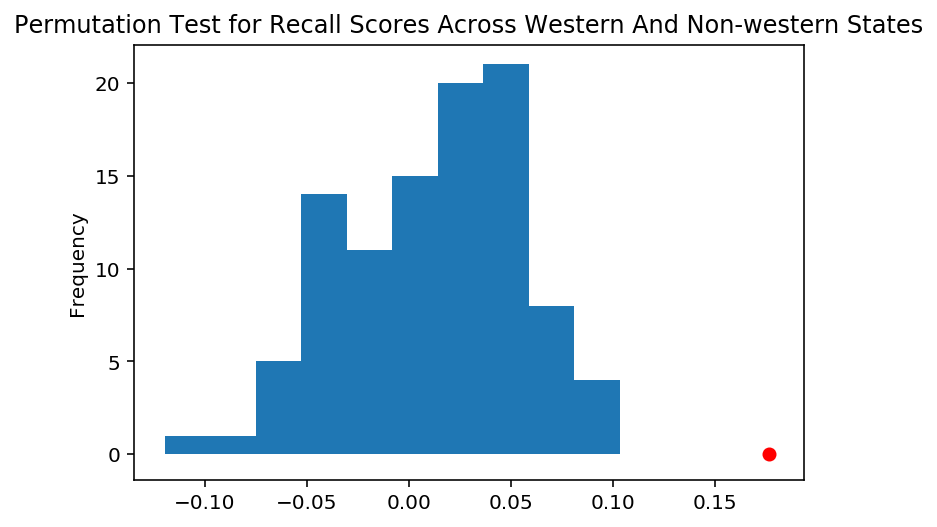

In [41]:
print('p-value', (results >= observed_diff.values[0]).mean())
pd.Series(results).plot(kind='hist', title='Permutation Test for Recall Scores Across Western And Non-western States')
plt.scatter(observed_diff, 0, c='r');